# Universidad Central de Venezuela
## Facultad de Ciencias
### Escuela de Computación
#### Aprendizaje Automático

**Joiner Rojas V29501730**

## Tarea #2 

# 1-B Modelo de clasificación de Operadores

En esta sección, se detallan los pasos para el preprocesamiento y transformación de los datos, así como la implementación de los modelos de Regresión Logística, k-Vecinos más Cercanos (k-NN) y Máquinas de Soporte Vectorial (SVM).

## Carga y Preprocesamiento de los Datos

El primer paso consiste en cargar y preprocesar el dataset. 

Este Dtaset fue creado por un grupo de 5 estudiantes de la materia. Se realizaron los operadores sobre un canvas fondo negro y los trazos en blanco con stroke entre 2 y 5 para generar varianza

### Importación de Librerias 

En esta sección, importamos todas las librerías necesarias para trabajar con el dataset MNIST y realizar el preprocesamiento de datos. Las librerías son colecciones de código que nos proporcionan funciones y herramientas útiles. En este caso, utilizamos librerías para manejar datos, crear gráficos, y trabajar con modelos de machine learning.

In [1]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import pandas as pd
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

seed=29501730
np.random.seed(seed)

### Carga del Dataset

Primero, necesitamos cargar el dataset, que contiene imágenes de dígitos manuscritos de los operadores. 

In [2]:
!git clone https://github.com/HandlessCoder/Dataset_Operadores_28x28.git
%cd Dataset_Operadores_28x28/
!git checkout prueba


c:\Users\joine\OneDrive\UCV2\SEMESTRE 2-2024\ML\Tareas\Tarea #2\[ML]-Tarea2-JoinerRojas-V29501730\src\notebooks\Dataset_Operadores_28x28


Cloning into 'Dataset_Operadores_28x28'...
c:\Users\joine\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


branch 'prueba' set up to track 'origin/prueba'.


Switched to a new branch 'prueba'


In [3]:
# Función para cargar imágenes
def load_images(root, label):
    images = []
    labels = []

    for filename in os.listdir(root):
        img = Image.open(os.path.join(root, filename)).convert("L")
        img = img.resize((28, 28))  # Redimensionar las imágenes a 28x28 píxeles
        img_np = np.array(img)  # Convertir la imagen a un arreglo de NumPy
        images.append(img_np)
        labels.append(label)
    return np.array(images), np.array(labels)

# Definir la ruta donde están las imágenes de operadores
root = ""

# Cargar las imágenes y etiquetas para cada operador
img_suma, label_suma = load_images(root + "Suma", ord('+'))  # Suma
img_resta, label_resta = load_images(root + "Resta", ord('-'))  # Resta
img_div1, label_div1 = load_images(root + "Division1", ord('/'))  # División1 -> /
img_div2, label_div2 = load_images(root + "Division2", ord('÷'))  # División2 -> ÷
img_mult1, label_mult1 = load_images(root + "Multiplicacion1", ord('*'))  # Multiplicación1 -> *
img_mult2, label_mult2 = load_images(root + "Multiplicacion2", ord('×'))  # Multiplicación2 -> ×

# Combinar todas las imágenes y etiquetas
all_images = np.concatenate([img_suma, img_resta, img_div1, img_div2, img_mult1, img_mult2])
all_labels = np.concatenate([label_suma, label_resta, label_div1, label_div2, label_mult1, label_mult2])

# Mezclar las imágenes y etiquetas usando la semilla, esto con el objetivo de dividir el dataset de manera random utilizando la cédula como parámetro
indices = np.arange(all_images.shape[0])
np.random.shuffle(indices)
all_images = all_images[indices]
all_labels = all_labels[indices]

# Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba), estos porcentajes de división
# son un criterio heredado de la asignatura Minería de Datos (fue el usado en regresión lineal)
trainImages, testImages, trainLabels, testLabels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=seed
)



### Preprocesamiento y exploración

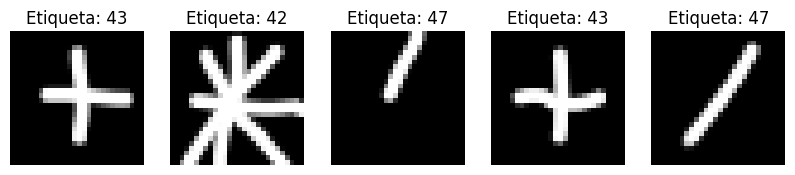

In [4]:

# Redimensionar y normalizar las imágenes
trainImages = trainImages.reshape((trainImages.shape[0], 28 * 28)).astype('float32') / 255
testImages = testImages.reshape((testImages.shape[0], 28 * 28)).astype('float32') / 255

# Convertir las etiquetas a categorías
trainLabels = to_categorical(trainLabels)
testLabels = to_categorical(testLabels)

# Convertir las etiquetas de vuelta a su formato original
trainLabels = np.argmax(trainLabels, axis=1)
testLabels = np.argmax(testLabels, axis=1)

# Mostrar algunas imágenes de entrenamiento
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(trainImages[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Etiqueta: {trainLabels[i]}")
    ax.axis('off')
plt.show()

Hemos completado el preprocesamiento del dataset, transformando nuestras imágenes y etiquetas para prepararlas adecuadamente para su uso en modelos de machine learning.

## Implementación de Modelos


En esta sección se implementan tres modelos de clasificación diferentes: Regresión Logística, k-Vecinos más Cercanos (k-NN), y Máquinas de Soporte Vectorial (SVM). Para cada modelo, se ajustan los hiperparámetros utilizando `GridSearchCV` y se evalúa el rendimiento.

### Regresión Logística

La regresión logística es un modelo de clasificación que se utiliza para predecir una variable categórica. En nuestro caso, usaremos la regresión logística para predecir qué operador está en una imagen del dataset.

#### Búsqueda de Hiperparámetros 

In [5]:
# Definir el modelo y los hiperparámetros a ajustar
param_grid_LR = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search_LR = GridSearchCV(LogisticRegression(max_iter=500), param_grid_LR, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_LR.fit(trainImages, trainLabels)

# Resultados de la búsqueda de hiperparámetros
print("=" * 30)
print("Resultados obtenidos:")
print("=" * 30)
print(f"Hiperparámetros encontrados: {grid_search_LR.best_params_}")
print("\nMétricas del modelo:")
print(f"Precisión (Accuracy): {grid_search_LR.best_score_ * 100:.2f}%")
print("=" * 30)


Resultados obtenidos:
Hiperparámetros encontrados: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}

Métricas del modelo:
Precisión (Accuracy): 91.60%


#### Evaluación del modelo

In [6]:
# Evaluar el mejor modelo en el conjunto de prueba
best_model_LR = grid_search_LR.best_estimator_
lr_predictions = best_model_LR.predict(testImages)

lr_accuracy = accuracy_score(testLabels, lr_predictions)
lr_precision = precision_score(testLabels, lr_predictions, average='weighted')
lr_recall = recall_score(testLabels, lr_predictions, average='weighted')
lr_f1 = f1_score(testLabels, lr_predictions, average='weighted')

print(f"Precisión del modelo en el conjunto de prueba (accuracy): {lr_accuracy * 100:.2f}%")
print(f"Exactitud (Precision): {lr_precision * 100:.2f}%")
print(f"Recall: {lr_recall * 100:.2f}%")
print(f"F1 Score: {lr_f1 * 100:.2f}%")


Precisión del modelo en el conjunto de prueba (accuracy): 89.60%
Exactitud (Precision): 90.21%
Recall: 89.60%
F1 Score: 89.70%


El modelo refleja una alta proporción de predicciones correctas. Es  Muy preciso en las predicciones positivas, minimizando falsos positivos. Identifica correctamente la mayoría de las instancias positivas. Buen equilibrio entre exactitud y sensibilidad, confirmando su robustez.

### K-Vecinos más Cercanos (k-NN)

k-NN clasifica un dato basándose en los 'k' puntos más cercanos en el conjunto de datos.'k' es el número de vecinos a considerar.

##### ¿Cómo Funciona? 

Calcula la distancia entre el punto nuevo y todos los puntos del conjunto de entrenamiento.Selecciona los 'k' puntos más cercanos.Asigna la clase más común entre estos 'k' vecinos al punto nuevo.

#### Búsqueda de Hiperparámetros 

In [7]:
# Definir el modelo y los hiperparámetros a ajustar
param_grid_kNN = {
    'n_neighbors': [3, 5, 7, 9],  # Prueba diferentes valores de k
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search_kNN = GridSearchCV(KNeighborsClassifier(), param_grid_kNN, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_kNN.fit(trainImages, trainLabels)

# Resultados de la búsqueda de hiperparámetros
print("=" * 30)
print("Resultados obtenidos:")
print("=" * 30)
print(f"Hiperparámetros encontrados: {grid_search_kNN.best_params_}")
print("\nMétricas del modelo:")
print(f"Precisión (Accuracy): {grid_search_kNN.best_score_ * 100:.2f}%")
print("=" * 30)




Resultados obtenidos:
Hiperparámetros encontrados: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}

Métricas del modelo:
Precisión (Accuracy): 92.40%


#### Evaluación del modelo

In [8]:
# Evaluar el mejor modelo en el conjunto de prueba
best_model_kNN = grid_search_kNN.best_estimator_
knn_predictions = best_model_kNN.predict(testImages)

knn_accuracy = accuracy_score(testLabels, knn_predictions)
knn_precision = precision_score(testLabels, knn_predictions, average='weighted')
knn_recall = recall_score(testLabels, knn_predictions, average='weighted')
knn_f1 = f1_score(testLabels, knn_predictions, average='weighted')

print(f"Precisión del modelo k-NN en el conjunto de prueba: {knn_accuracy * 100:.2f}%")
print(f"Precisión (Precision): {knn_precision * 100:.2f}%")
print(f"Recall: {knn_recall * 100:.2f}%")
print(f"F1 Score: {knn_f1 * 100:.2f}%")


Precisión del modelo k-NN en el conjunto de prueba: 89.60%
Precisión (Precision): 90.37%
Recall: 89.60%
F1 Score: 89.50%


### Máquinas de Soporte Vectorial

Las Máquinas de Soporte Vectorial (SVM) son algoritmos de machine learning utilizados para la clasificación y regresión. Su objetivo principal es encontrar el hiperplano que mejor separa las diferentes clases en los datos.

#### Búsqueda de Hiperparámetros 

In [9]:
# Ajuste de hiperparámetros para Máquinas de Soporte Vectorial (SVM)
param_grid_SVM = {
    'C': [0.1, 1, 10],  # Puedes ajustar estos valores según sea necesario
    'kernel': ['linear', 'rbf', 'poly'],  # Añadir 'poly' para mayor exhaustividad
    'gamma': ['scale', 'auto']  # Añadir 'auto' para mayor exhaustividad
}

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search_SVM = GridSearchCV(SVC(), param_grid_SVM, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_SVM.fit(trainImages, trainLabels)

# Resultados de la búsqueda de hiperparámetros
print("=" * 30)
print("Resultados obtenidos:")
print("=" * 30)
print(f"Hiperparámetros encontrados: {grid_search_SVM.best_params_}")
print("\nMétricas del modelo:")
print(f"Precisión (Accuracy): {grid_search_SVM.best_score_ * 100:.2f}%")
print("=" * 30)



Resultados obtenidos:
Hiperparámetros encontrados: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Métricas del modelo:
Precisión (Accuracy): 95.20%


#### Evaluación del modelo

In [10]:
# Evaluar el mejor modelo SVM
best_model_SVM = grid_search_SVM.best_estimator_
svm_predictions = best_model_SVM.predict(testImages)

svm_accuracy = accuracy_score(testLabels, svm_predictions)
svm_precision = precision_score(testLabels, svm_predictions, average='weighted')
svm_recall = recall_score(testLabels, svm_predictions, average='weighted')
svm_f1 = f1_score(testLabels, svm_predictions, average='weighted')

print(f"Mejores hiperparámetros para SVM: {grid_search_SVM.best_params_}")
print(f"Precisión del modelo SVM en el conjunto de prueba: {svm_accuracy * 100:.2f}%")
print(f"Precisión (Precision): {svm_precision * 100:.2f}%")
print(f"Recall: {svm_recall * 100:.2f}%")
print(f"F1 Score: {svm_f1 * 100:.2f}%")

Mejores hiperparámetros para SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Precisión del modelo SVM en el conjunto de prueba: 93.60%
Precisión (Precision): 93.93%
Recall: 93.60%
F1 Score: 93.64%


## Seleccion del Modelo más eficiente

                 Model  Accuracy  Precision  Recall  F1 Score
0  Logistic Regression     0.896   0.902114   0.896  0.897017
1                 k-NN     0.896   0.903665   0.896  0.895021
2                  SVM     0.936   0.939349   0.936  0.936411


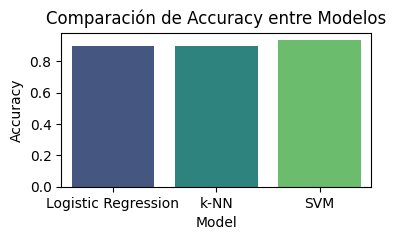

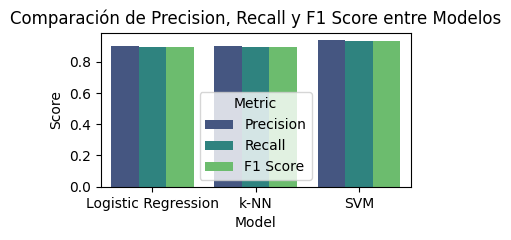

In [ ]:
# Guardar métricas en un diccionario
metrics = {
    'Model': ['Logistic Regression', 'k-NN', 'SVM'],
    'Accuracy': [lr_accuracy, knn_accuracy, svm_accuracy],
    'Precision': [lr_precision, knn_precision, svm_precision],
    'Recall': [lr_recall, knn_recall, svm_recall],
    'F1 Score': [lr_f1, knn_f1, svm_f1]
}

# Convertir el diccionario en un DataFrame
metrics_df = pd.DataFrame(metrics)

# Mostrar la tabla
print(metrics_df)

# Gráfica de barras con Seaborn para Accuracy
plt.figure(figsize=(4, 2))  # Reducir tamaño de la gráfica
sns.barplot(x='Model', y='Accuracy', hue='Model', data=metrics_df, palette='viridis', dodge=False)
plt.title('Comparación de Accuracy entre Modelos')
plt.legend([], [], frameon=False)  # Eliminar leyenda redundante
plt.show()

# Gráfica de barras para Precision, Recall y F1 Score
plt.figure(figsize=(4, 2))  # Reducir tamaño de la gráfica
metrics_melted = metrics_df.melt(id_vars='Model', value_vars=['Precision', 'Recall', 'F1 Score'], var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_melted, palette='viridis')
plt.title('Comparación de Precision, Recall y F1 Score entre Modelos')
plt.show()

En base a los resultados el modelo SVM es el mejor a usar en este caso. Esto se debe a que SVM tiene la mayor Accuracy (0.936), Precision (0.939349), Recall (0.936) y F1 Score (0.936411) en comparación con Logistic Regression y k-NN. Estas métricas indican que SVM tiene un mejor rendimiento general en términos de precisión y capacidad para identificar correctamente las clases positivas y negativas.



## Exportar el Modelo

In [30]:
# Supongamos que has decidido usar el modelo SVM como modelo definitivo
final_model = best_model_SVM
# Ruta relativa para guardar el modelo directamente en "models/output"
ruta_modelo = os.path.join('..', '..', 'models', 'output', 'OperatorsModel.joblib')


# Guardar el modelo en un archivo
joblib.dump(final_model, ruta_modelo)

print(f"Modelo guardado en {ruta_modelo}")


Modelo guardado en ..\..\models\output\OperatorsModel.joblib
